<a href="https://colab.research.google.com/github/4lparslan/Image_Segmentation/blob/main/Person_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=41af09ff94e2942a4a5c1a82e6c729b835d3e8f5ef741b41f7c38b49faf03251
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=347790f1db7df094985c58c89038e5764353d2203313a642f609b893d11e1ede
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
pip install kaggle

In [ ]:
# Get your kaggle API Key as kaggle.json
# Then run the codes below

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d tapakah68/supervisely-filtered-segmentation-person-dataset

100% 4.30G/4.31G [00:48<00:00, 153MB/s]
100% 4.31G/4.31G [00:48<00:00, 95.0MB/s]


In [5]:
!unzip supervisely-filtered-segmentation-person-dataset.zip

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images/ds2_person-human-female-girl.png  
  inflating: supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images/ds2_person-woman-coffee-cup.png  
  inflating: supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images/ds2_person-woman-eyes-face.png  
  inflating: supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images/ds2_person-woman-hotel-laptop.png  
  inflating: supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images/ds2_pexels-photo-105472.png  
  inflating: supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images/ds2_pexels-photo-123318.png  
  inflating: supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images/ds2_pexels-photo-125522.png  
  inflating: supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images/ds2_pexels-photo-1262

In [6]:
# Arrange dataset folder name and location
import shutil
import os
source_folder = 'supervisely_person_clean_2667_img/supervisely_person_clean_2667_img'
des_folder = 'person-dataset'
shutil.move(source_folder, des_folder)
os.rmdir('supervisely_person_clean_2667_img')


# Some Common Imports

In [7]:
import sys
sys.path.append('/content/person_dataset')

In [8]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

Helper function for showing images:

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch


def show_image(image,mask,pred_image = None):

    if pred_image == None:

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

    elif pred_image != None :

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')




# Task : 2 Setup Configurations

In [10]:
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25

# Learning Rate
LR = 0.003

IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [11]:
images_folder = 'person-dataset/images/'
masks_folder = 'person-dataset/masks/'

image_files = sorted(os.listdir(images_folder))
mask_files = sorted(os.listdir(masks_folder))

data = {'images': [os.path.join(images_folder, filename) for filename in image_files],
        'masks': [os.path.join(masks_folder, filename) for filename in mask_files]}

### optional: save as csv file###
#df = pd.DataFrame(data)
#df.to_csv('df.csv', index=False)

In [12]:
# dataframe
df = pd.DataFrame(data)

df.head()


,images,masks
0,person-dataset/images/ds10_pexels-photo-687782...,person-dataset/masks/ds10_pexels-photo-687782.png
1,person-dataset/images/ds10_pexels-photo-835971...,person-dataset/masks/ds10_pexels-photo-835971.png
2,person-dataset/images/ds10_pexels-photo-850708...,person-dataset/masks/ds10_pexels-photo-850708.png
3,person-dataset/images/ds10_pexels-photo-864937...,person-dataset/masks/ds10_pexels-photo-864937.png
4,person-dataset/images/ds10_pexels-photo-865908...,person-dataset/masks/ds10_pexels-photo-865908.png


In [13]:
row = df.iloc[150]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

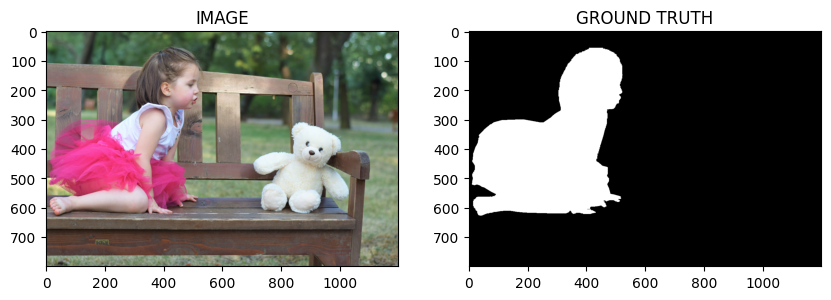

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [15]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [16]:
import albumentations as A

In [17]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE)
], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [18]:
from torch.utils.data import Dataset

In [19]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    # (h, w, c) -> (c, h, w)
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    # np to tensor
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [20]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [21]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 2133
Size of Validset : 534


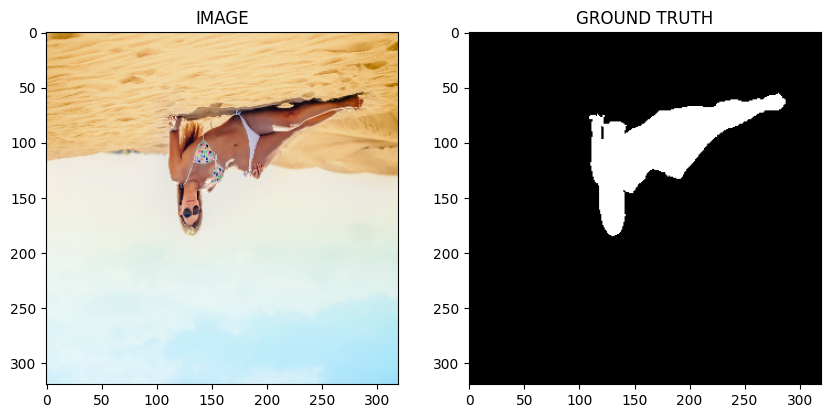

In [22]:
idx = 150
image, mask = trainset[idx]
show_image(image, mask)

# Task 5 : Load dataset into batches

In [23]:
from torch.utils.data import DataLoader

In [24]:
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
valid_loader = DataLoader(validset, batch_size=BATCH_SIZE)

In [25]:
print(f"Total number of batches in train_loader: {len(train_loader)}")
print(f"Total number of batches in valid_loader: {len(valid_loader)}")

Total number of batches in train_loader: 134
Total number of batches in valid_loader: 34


In [26]:
for image, mask in train_loader:
  break
print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

# batch_size, channel, height, width

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [27]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [28]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    #architecture
    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )
  def forward(self, images, masks=None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2
    return logits



In [29]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 149MB/s] 


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [30]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  # average loss
  return total_loss / len(data_loader)

In [31]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)


      total_loss += loss.item()

  # average loss
  return total_loss / len(data_loader)

# Task 8 : Train Model

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [33]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(train_loader, model, optimizer)
  valid_loss = eval_fn(valid_loader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Saved Model")
    best_valid_loss = valid_loss

  print(f"Epoch: {i+1} Train Loss: {train_loss} Valid Loss: {valid_loss}")

100%|██████████| 34/34 [00:38<00:00,  1.13s/it]


Saved Model
Epoch: 1 Train Loss: 0.43297659349975304 Valid Loss: 0.35180117189884186


100%|██████████| 34/34 [00:38<00:00,  1.12s/it]


Saved Model
Epoch: 2 Train Loss: 0.29765333757916496 Valid Loss: 0.3008989775005509


100%|██████████| 34/34 [00:37<00:00,  1.12s/it]


Saved Model
Epoch: 3 Train Loss: 0.24997654040135556 Valid Loss: 0.2311057439621757


100%|██████████| 34/34 [00:38<00:00,  1.13s/it]


Saved Model
Epoch: 4 Train Loss: 0.24475932855214647 Valid Loss: 0.2260230814709383


100%|██████████| 34/34 [00:38<00:00,  1.13s/it]


Epoch: 5 Train Loss: 0.21096510651396283 Valid Loss: 0.22779527438037536


100%|██████████| 34/34 [00:39<00:00,  1.16s/it]


Saved Model
Epoch: 6 Train Loss: 0.20695075092475806 Valid Loss: 0.20504247156136177


100%|██████████| 34/34 [00:37<00:00,  1.12s/it]


Epoch: 7 Train Loss: 0.18723430212086706 Valid Loss: 0.21534843611366608


100%|██████████| 34/34 [00:37<00:00,  1.09s/it]


Epoch: 8 Train Loss: 0.19810172131479675 Valid Loss: 0.2670240244444679


100%|██████████| 34/34 [00:37<00:00,  1.10s/it]


Saved Model
Epoch: 9 Train Loss: 0.17814945807652688 Valid Loss: 0.1644372195005417


100%|██████████| 34/34 [00:38<00:00,  1.14s/it]


Epoch: 10 Train Loss: 0.16997926982481087 Valid Loss: 0.20339059917365804


100%|██████████| 34/34 [00:38<00:00,  1.12s/it]


Epoch: 11 Train Loss: 0.22685361798129863 Valid Loss: 0.19928238716195612


100%|██████████| 34/34 [00:38<00:00,  1.12s/it]


Epoch: 12 Train Loss: 0.17590608620154324 Valid Loss: 0.17712757670704057


100%|██████████| 34/34 [00:38<00:00,  1.13s/it]


Epoch: 13 Train Loss: 0.15370243326274316 Valid Loss: 0.1818672265200054


100%|██████████| 34/34 [00:39<00:00,  1.16s/it]


Epoch: 14 Train Loss: 0.133230649629858 Valid Loss: 0.17700085109647581


100%|██████████| 34/34 [00:38<00:00,  1.14s/it]


Epoch: 15 Train Loss: 0.13849462702203152 Valid Loss: 0.19199144401971033


100%|██████████| 34/34 [00:38<00:00,  1.13s/it]


Saved Model
Epoch: 16 Train Loss: 0.1469260366327727 Valid Loss: 0.16282886639237404


100%|██████████| 34/34 [00:38<00:00,  1.14s/it]


Epoch: 17 Train Loss: 0.1360632393564751 Valid Loss: 0.18813152874217315


100%|██████████| 34/34 [00:38<00:00,  1.13s/it]


Epoch: 18 Train Loss: 0.12749501523464474 Valid Loss: 0.17769300630863974


100%|██████████| 34/34 [00:38<00:00,  1.14s/it]


Epoch: 19 Train Loss: 0.12066218790723317 Valid Loss: 0.17934508380644462


100%|██████████| 34/34 [00:38<00:00,  1.14s/it]


Epoch: 20 Train Loss: 0.12210973986049196 Valid Loss: 0.1740015381399323


100%|██████████| 34/34 [00:38<00:00,  1.13s/it]


Epoch: 21 Train Loss: 0.12158251592694823 Valid Loss: 0.18322854269953334


100%|██████████| 34/34 [00:38<00:00,  1.14s/it]


Epoch: 22 Train Loss: 0.12842555066098027 Valid Loss: 0.21672975885517456


100%|██████████| 34/34 [00:38<00:00,  1.14s/it]


Epoch: 23 Train Loss: 0.12207014497313927 Valid Loss: 0.16339056456790252


100%|██████████| 34/34 [00:38<00:00,  1.14s/it]


Saved Model
Epoch: 24 Train Loss: 0.10782134902677429 Valid Loss: 0.15563471790622263


100%|██████████| 34/34 [00:39<00:00,  1.16s/it]

Epoch: 25 Train Loss: 0.10824135613085618 Valid Loss: 0.16281259125646422


# Task 9 : Inference

In [37]:
idx = 10

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

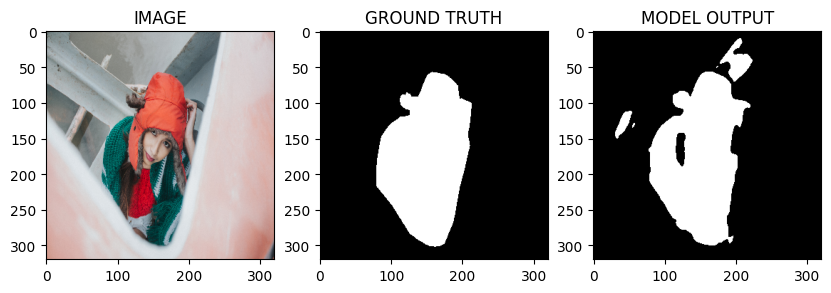

In [38]:
show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya